In [15]:
import glob
import os
import time
import csv

os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID' 
os.environ['CUDA_VISIBLE_DEVICES']='0'

from stargan2.solver import Solver

import numpy as np

import matplotlib.pyplot as plt
import torch

from torch.backends import cudnn
cudnn.benchmark = True

In [6]:
import torchvision.datasets as datasets
from itertools import groupby
import random
from PIL import Image

class ReferenceDataset(datasets.DatasetFolder):
    def __init__(
            self,
            root,
            transform = None,
            target_transform = None,
            loader = datasets.folder.default_loader,
            is_valid_file = None,
    ):
        super(StarGANImageFolder, self).__init__(root, loader, 
                                          datasets.folder.IMG_EXTENSIONS if is_valid_file is None else None,
                                          transform=transform,
                                          target_transform=target_transform,
                                          is_valid_file=is_valid_file)
        
        # group samples by label
        groupped = {k: list(v) for k, v in  groupby(self.samples, lambda x: x[1])}
        
        # crate reference images
        self.references = []
        targets = []
        for domain, values in groupped.items():
            # unzip samples and targets
            samples, _ = zip(*values)
            # shuffle second reference images
            samples2 = random.sample(samples, len(samples))
            # repeat labels
            labels = [domain]*len(samples)
            targets+= labels
            self.references+= list(zip(samples, samples2, labels))
        
        # to make sure that the samples have corresponding labels
        self.targets = targets
        # shuffle zipped references   
#         self.references = random.sample(references, len(references))
        
    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (ref sample 1, ref sample 2, ref target)
        """
#         path, target = self.samples[index]
        ref_path1, ref_path2, ref_target = self.references[index]

#         sample = self.loader(path)
        ref1 = self.loader(ref_path1)
        ref2 = self.loader(ref_path2)
        
        if self.transform is not None:
#             sample = self.transform(sample)
            ref1 = self.transform(ref1)
            ref2 = self.transform(ref2)
            
        if self.target_transform is not None:
#             target = self.target_transform(target)
            ref_target = self.target_transform(ref_target)

        return ref1, ref2, ref_target


In [11]:
from torchvision import transforms

img_size = 256
transform = transforms.Compose([
    transforms.Resize([img_size, img_size]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5]),
])

ds = StarGANImageFolder('/home/aray/stargan-v2/data/afhq/train', transform)


sampler = _make_balanced_sampler(dataset.targets)
loader = DataLoader(dataset=ds,
                       batch_size=8,
                       sampler=sampler,
                       num_workers=4,
                       pin_memory=True,
                       drop_last=True)


In [23]:
from torch.utils.data.sampler import WeightedRandomSampler

class_counts = np.bincount(ds.targets)
class_weights = 1. / class_counts
weights = class_weights[ds.targets]
WeightedRandomSampler(weights, len(weights))

In [25]:
weights.sum()

3.0

In [132]:
"""
StarGAN v2
Copyright (c) 2020-present NAVER Corp.

This work is licensed under the Creative Commons Attribution-NonCommercial
4.0 International License. To view a copy of this license, visit
http://creativecommons.org/licenses/by-nc/4.0/ or send a letter to
Creative Commons, PO Box 1866, Mountain View, CA 94042, USA.
"""

from pathlib import Path
from itertools import chain
import os

from munch import Munch
import numpy as np

import torch
from torch.utils import data
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision import transforms
from torchvision.datasets import ImageFolder


def listdir(dname):
    fnames = list(chain(*[list(Path(dname).rglob('*.' + ext))
                          for ext in ['png', 'jpg', 'jpeg', 'JPG']]))
    return fnames


class DefaultDataset(data.Dataset):
    def __init__(self, root, transform=None):
        self.samples = listdir(root)
        self.samples.sort()
        self.transform = transform
        self.targets = None

    def __getitem__(self, index):
        fname = self.samples[index]
        img = Image.open(fname).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        return img

    def __len__(self):
        return len(self.samples)


class ReferenceDataset(data.Dataset):
    def __init__(self, root, transform=None):
        self.samples, self.targets = self._make_dataset(root)
        self.transform = transform

    def _make_dataset(self, root):
        domains = os.listdir(root)
        fnames, fnames2, labels = [], [], []
        for idx, domain in enumerate(sorted(domains)):
            class_dir = os.path.join(root, domain)
            cls_fnames = listdir(class_dir)
            fnames += cls_fnames
            fnames2 += random.sample(cls_fnames, len(cls_fnames))
            labels += [idx] * len(cls_fnames)
        return list(zip(fnames, fnames2)), labels

    def __getitem__(self, index):
        fname, fname2 = self.samples[index]
        label = self.targets[index]
        img = Image.open(fname).convert('RGB')
        img2 = Image.open(fname2).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
            img2 = self.transform(img2)
        return img, img2, label

    def __len__(self):
        return len(self.targets)


def _make_balanced_sampler(labels):
    class_counts = np.bincount(labels)
    class_weights = 1. / class_counts
    weights = class_weights[labels]
    return WeightedRandomSampler(weights, len(weights))


def get_train_loader(root, which='source', img_size=256,
                     batch_size=8, prob=0.5, num_workers=4):
    print('Preparing DataLoader to fetch %s images '
          'during the training phase...' % which)

    crop = transforms.RandomResizedCrop(
        img_size, scale=[0.8, 1.0], ratio=[0.9, 1.1])
    rand_crop = transforms.Lambda(
        lambda x: crop(x) if random.random() < prob else x)

    transform = transforms.Compose([
        rand_crop,
        transforms.Resize([img_size, img_size]),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                             std=[0.5, 0.5, 0.5]),
    ])

    if which == 'source':
        dataset = ImageFolder(root, transform)
    elif which == 'reference':
        dataset = ReferenceDataset(root, transform)
    else:
        raise NotImplementedError

    sampler = _make_balanced_sampler(dataset.targets)
    return data.DataLoader(dataset=dataset,
                           batch_size=batch_size,
                           sampler=sampler,
                           num_workers=num_workers,
                           pin_memory=True,
                           drop_last=True)


def get_eval_loader(root, img_size=256, batch_size=32,
                    imagenet_normalize=True, shuffle=True,
                    num_workers=4, drop_last=False):
    print('Preparing DataLoader for the evaluation phase...')
    if imagenet_normalize:
        height, width = 299, 299
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
    else:
        height, width = img_size, img_size
        mean = [0.5, 0.5, 0.5]
        std = [0.5, 0.5, 0.5]

    transform = transforms.Compose([
        transforms.Resize([img_size, img_size]),
        transforms.Resize([height, width]),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

    dataset = DefaultDataset(root, transform=transform)
    return data.DataLoader(dataset=dataset,
                           batch_size=batch_size,
                           shuffle=shuffle,
                           num_workers=num_workers,
                           pin_memory=True,
                           drop_last=drop_last)


def get_test_loader(root, img_size=256, batch_size=32,
                    shuffle=True, num_workers=4):
    print('Preparing DataLoader for the generation phase...')
    transform = transforms.Compose([
        transforms.Resize([img_size, img_size]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                             std=[0.5, 0.5, 0.5]),
    ])

    dataset = ImageFolder(root, transform)
    return data.DataLoader(dataset=dataset,
                           batch_size=batch_size,
                           shuffle=shuffle,
                           num_workers=num_workers,
                           pin_memory=True)


class InputFetcher:
    def __init__(self, loader, loader_ref=None, latent_dim=16, mode=''):
        self.loader = loader
        self.loader_ref = loader_ref
        self.latent_dim = latent_dim
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.mode = mode

    def _fetch_inputs(self):
        try:
            x, y = next(self.iter)
        except (AttributeError, StopIteration):
            self.iter = iter(self.loader)
            x, y = next(self.iter)
        return x, y

    def _fetch_refs(self):
        try:
            x, x2, y = next(self.iter_ref)
        except (AttributeError, StopIteration):
            self.iter_ref = iter(self.loader_ref)
            x, x2, y = next(self.iter_ref)
        return x, x2, y

    def __next__(self):
        x, y = self._fetch_inputs()
        if self.mode == 'train':
            x_ref, x_ref2, y_ref = self._fetch_refs()
            z_trg = torch.randn(x.size(0), self.latent_dim)
            z_trg2 = torch.randn(x.size(0), self.latent_dim)
            inputs = Munch(x_src=x, y_src=y, y_ref=y_ref,
                           x_ref=x_ref, x_ref2=x_ref2,
                           z_trg=z_trg, z_trg2=z_trg2)
        elif self.mode == 'val':
            x_ref, y_ref = self._fetch_inputs()
            inputs = Munch(x_src=x, y_src=y,
                           x_ref=x_ref, y_ref=y_ref)
        elif self.mode == 'test':
            inputs = Munch(x=x, y=y)
        else:
            raise NotImplementedError

        return Munch({k: v.to(self.device)
                      for k, v in inputs.items()})

In [134]:
rds = ReferenceDataset('/home/aray/stargan-v2/data/afhq/train')

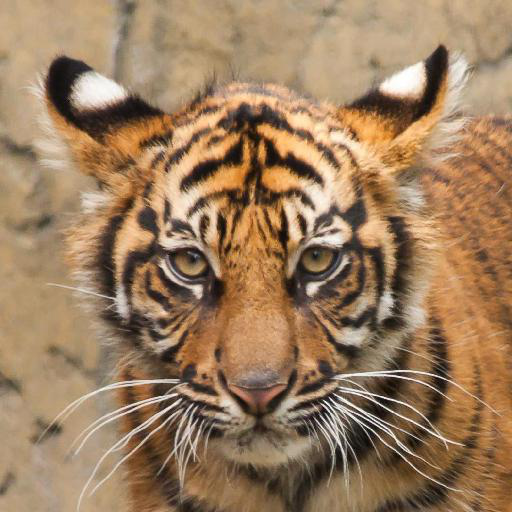

In [225]:
rds[10000][0]

In [131]:
ds.groupped.keys()

dict_keys([0, 1, 2])

In [127]:
g.keys()

dict_keys([0, 1, 2])

In [102]:
dir = '/home/aray/stargan-v2/data/afhq/train'
classes = [d.name for d in os.scandir(dir) if d.is_dir()]
classes.sort()
class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}

In [103]:
class_to_idx

{'cat': 0, 'dog': 1, 'wild': 2}

In [ ]:
folder.make_dataset(dir, class_to_idx, None, lambda x: True)

In [68]:
ds = ImageFolder('~/stargan-v2/data/afhq')

In [84]:
ds.__len__()

16130

In [97]:
ds[1133][1]

0

In [2]:
X0 = np.concatenate([np.load('X0_train_clean_48.npy'), np.load('X0_val_clean_48.npy')])
X1 = np.concatenate([np.load('X1_train_clean_48.npy'), np.load('X1_val_clean_48.npy')])

X = np.concatenate((X0, X1))
y = np.concatenate((np.zeros(len(X0)), np.ones(len(X1)))).astype(np.long)

In [ ]:
solver = Solver(X, y, 2)
solver.train(10, 16)

In [28]:
def imshow(img):
    img = img.numpy()[0]
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)

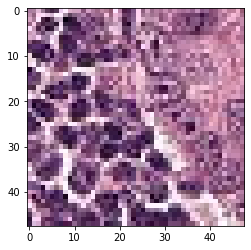

In [32]:
i = np.random.randint(len(X0))
x_ref = torch.from_numpy(X0[i][None])
imshow(x_ref)

torch.Size([1, 3, 48, 48])

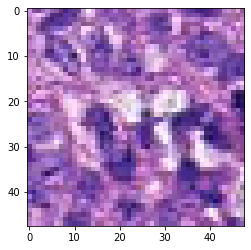

In [40]:
i = np.random.randint(len(X1))
x_real = torch.from_numpy(X1[i][None])
imshow(x_real)
x_real.shape

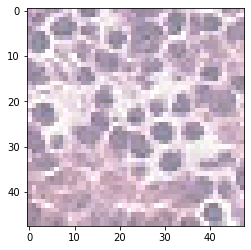

In [62]:
y_trg = torch.tensor([0]).cuda()
# s_trg = solver.style_encoder(x_ref.cuda(), y_trg)

z = torch.randn(1, solver.latent_dim).cuda()
s_trg = solver.mapping_network(z, y_trg)

x_result = ((1+solver.G(x_real.cuda(), s_trg))/2).clamp_(0, 1)
imshow(x_result.detach().cpu())

In [61]:
((x_result+1)/2).min()

tensor(0.4760, device='cuda:0', grad_fn=<MinBackward1>)